ЗАГРУЗКА БИБЛИОТЕК И ДАТАСЕТОВ

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [13]:
#Загрузка датасетов
submission_data_test = pd.read_csv(r"C:\Users\User\Desktop\test project\submission_data_test.csv")
submission_data_train = pd.read_csv(r"C:\Users\User\Desktop\test project\submissions_data_train.csv")
events_data_test = pd.read_csv(r"C:\Users\User\Desktop\test project\events_data_test.csv")
events_data_train = pd.read_csv(r"C:\Users\User\Desktop\test project\event_data_train.csv")

СОЗДАДИМ ФУНКЦИИ РЕДАКТИРОВАНИЯ

In [14]:
def filtered_data(data, days=2):
    '''
    Фильтрация данных с порогом 2 дня от начала обучения. Из условия задачи.
    '''
    #Создаем колонку с первым действием пользователя
    r_side_to_merge = data.groupby('user_id', as_index=False) \
                        .agg({'timestamp':'min'}) \
                        .rename({'timestamp':'min_timestamp'}, axis=1)
    
    #Объединяем и фильтруем по времени + 2 дня от даты старта
    learning_time_threshold = days * 24 * 60 * 60
    data = data.merge(r_side_to_merge, on='user_id', how='outer')
    data = data[data.timestamp < (data.min_timestamp + learning_time_threshold)]
    
    #Проверяем что все пользователи на месте
    assert data.user_id.nunique() == data.user_id.nunique()
    return data.drop('min_timestamp', axis=1)


In [15]:
def create_base_feature(submission_data, events_data):
    '''
    Преобразование категориальных данных в числа и дальнейшее объединение в одну таблицу
    '''
    user_scores = submission_data.pivot_table(columns='submission_status', 
                                            values='step_id', 
                                            aggfunc='count', 
                                            index='user_id', 
                                            fill_value=0) \
                                            .reset_index() \
                                            .rename_axis('', axis=1)
    users_events_data = events_data.pivot_table(columns='action', 
                                            values='step_id', 
                                            aggfunc='count', 
                                            index='user_id',
                                            fill_value=0) \
                                            .reset_index() \
                                            .rename_axis('', axis=1)
    
    #Объединяем
    users_data = user_scores.merge(users_events_data, 
                                           on='user_id', 
                                           how='outer') \
                                           .fillna(0)
    
    #Проверяем что все пользователи на остались в данных
    assert events_data.user_id.nunique() == users_data.user_id.nunique()
    return users_data

In [16]:
def create_target(submission_data, threshold=40):
    '''
    Создаем таргет (колонку y) для расчета что будет считаться успешным прохождением теста. 
    По умолчанию принимаем 40 правильных ответов как точку прохождения курса.
    Значени принято на основании визуализации submission_data_test['correct_num'].hist(bins=50)
    '''

    #Создаем колонку с количеством правильных ответов
    users_count_correct = submission_data[submission_data['submission_status'] == 'correct'].groupby('user_id') \
                                            .agg({'submission_status':'count'}) \
                                            .reset_index()  \
                                            .rename({'submission_status':'correct_num'}, axis=1)
    
    #Фильтруем по ранее созданной колонке
    users_count_correct['passed_course'] = (users_count_correct['correct_num'] > threshold).astype('int')
    return users_count_correct.drop('correct_num', axis=1)


In [17]:
def time_features(event_data):
    '''
    Создаем колонку общего количества часов посвященных обучению
    '''
    events_data_train['date'] = pd.to_datetime(events_data_train['timestamp'], unit='s')
    events_data_train['day'] = pd.to_datetime(events_data_train['timestamp'], unit='s').dt.date

    users_time_feature = events_data_train.groupby('user_id') \
                                    .agg({'timestamp':['max', 'min'], 'day':'nunique'}) \
                                    .rename(columns={'nunique':'days'}) \
                                    .droplevel(0, axis=1) \
                                    .reset_index()

    users_time_feature['hours'] = round((users_time_feature['max'] - users_time_feature['min']) / 3600, 1)
    return users_time_feature.drop(['max', 'min'], axis=1)

In [18]:
def tries_feature(submission_data):
    '''
    Создаем колонку общего количества попыток решения заданий
    '''
    submission_data = submission_data.groupby('user_id', as_index=False) \
                                    .agg({'step_id':'nunique'}) \
                                    .rename({'step_id':'steps_tried'}, axis=1)
    return submission_data

In [19]:
def correct_ratio(submission_data):
    '''
    Добавляем колонку соотношения верных и неверных ответов пользователя
    '''
    submission_data['correct_ratio'] = submission_data['correct'] / (submission_data['correct'] + submission_data['wrong']).fillna(0)
    return submission_data

In [20]:
def create_df(submission_data, events_data):
    '''
    Функция для запуска остальных функций. Приведение сторон X-y к форме эффективной для обучения модели 
    '''
    # Фильтруем данные по первым 2 дням обучения для каждого студента
    submission_data_2days = filtered_data(submission_data)
    events_data_2days = filtered_data(events_data)

    # Добавляем базовые признакми и объединяем в единую таблицу
    users_data = create_base_feature(submission_data_2days, events_data_2days)

    #Создаем целевую переменную Y
    users_target_feature = create_target(submission_data, threshold=40)

    #Создаем доп признаки по времени и соотношению правильных/неправильных ответов
    time_column = time_features(events_data_2days)
    users_steps_tried = tries_feature(submission_data_2days)
    ratio_features = correct_ratio(users_data)

    #Объединяем с основной таблицей дополнительные вычисленные признаки
    first = users_data.merge(users_steps_tried, on='user_id', how='outer').fillna(0)
    second = first.merge(time_column, on='user_id', how='outer').fillna(0)
    third = second.merge(users_target_feature, on='user_id', how='outer').fillna(0)

    #Создаем целевую переменную X
    y = third['passed_course'].map(int)
    X = third.drop(['passed_course'], axis=1)
    
    return X, y

In [21]:
def create_test_df(submission_data, events_data):
    '''
    Подготавливаем Х-часть датасета на валидной (тестовой) выборке
    '''
    # Фильтруем данные по первым 2 дням обучения для каждого студента
    submissions_2days = filtered_data(submission_data)
    events_2days = filtered_data(events_data)

    # Добавляем базовые признакми и объединяем в единую таблицу
    users_data = create_base_feature(submission_data, events_data)

    #Создаем целевую переменную Y
    y = create_target(submission_data, threshold=40)

    #Создаем доп признаки по времени и соотношению правильных/неправильных ответов
    users_time_feature = time_features(events_2days)
    users_steps_tried = tries_feature(submissions_2days)
    users_data = correct_ratio(users_data)

    #Объединяем с основной таблицей дополнительные вычисленные признаки
    first = users_data.merge(users_time_feature, on='user_id', how='outer').fillna(0)
    X = first.merge(users_steps_tried, on='user_id', how='outer').fillna(0)
    
    return X

СОЗДАЕМ ДАТАСЕТЫ X-Y

In [34]:
#Создание треннировочного и тестового датасетов
X_train, y = create_df(submission_data_train, events_data_train)
X_test = create_test_df(submission_data_test, events_data_test)

#Приводим к одному порядку колонок
X_test = X_test[['user_id', 'correct', 'wrong', 'discovered', 'passed',
       'started_attempt', 'viewed', 'correct_ratio', 'steps_tried', 'days',
       'hours']]

ОБУЧАЕМ МОДЕЛЬ

In [48]:
def random_with_grid(train_data, y, size=0.20):
    """
    Поиск наилучших параметров с RandomForest на тренировочной выборке.
    """
    X_train, X_test, y_train, y_test = train_test_split(train_data, y, test_size=size, random_state=42)
    
    param_grid = {'randomforestclassifier__n_estimators': range(20, 51, 6), 
                  'randomforestclassifier__max_depth': range(5, 14),
                  'randomforestclassifier__bootstrap': [True]}
    #Используем RandomForest c GridSearchCV для поиска лучших параметров для обучения модели
    pipe = make_pipeline(RandomForestClassifier())
    pipe.fit(X_train, y_train) #активация make_pipeline
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"\033[1;30m\nЛУЧШИЕ ПАРАМЕТРЫ МОДЕЛИ ПОИСКА:\n\033[0m {grid.best_params_}")
    
    #Ищем значения при которых происходит валидация и формируем из них TRUE/FALSE POSITIVE соотношения
    ypred_prob = grid.predict_proba(X_test)
    roc_score = roc_auc_score(y_test, ypred_prob[:, 1])
    score = grid.score(X_test, y_test)
    print(f'\033[1;30m\nКОРРЕКТНОСТЬ НА ТЕСТОВОЙ ЧАСТИ ДАТАСЕТА : \033[0m{score:.2f}')
    print(f'\033[1;30mROC_AUC НА ТЕСТОВОЙ ЧАСТИ ДАТАСЕТА :\033[0m {roc_score:.2f}')
    
    #Покажем наиболее влияющие параметры на предсказание
    best_model = grid.best_estimator_.named_steps['randomforestclassifier']
    importance_frame = pd.DataFrame({'parameters_name': list(X_test), 
                  'importance_%':best_model.feature_importances_}) \
                    .sort_values('importance_%',ascending=False) \
                        .iloc[:3] \
                        .set_index('parameters_name',drop=True) \
                        .mul(100) \
                        .round(1)
    print(f'\033[1;30m\nНАИБОЛЕЕ ВЛИЯЮЩИЕ ПАРАМЕТРЫ: \n\033[0m{importance_frame}')
    
    #Изобразим график зависимости ROC_AUC
    lw=2
    fpr, tpr, thresholds = roc_curve(y_test, ypred_prob[:,1])
    roc_auc= auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FALSE_POSITIVE', fontsize=15)
    plt.ylabel('TRUE_POSITIVE', fontsize=15)
    plt.legend(loc="lower right")
    plt.figure(figsize=(10,8)).tight_layout()
    plt.show()

ЗАПУСКАЕМ ОБУЧЕНИЕ


ЛУЧШИЕ ПАРАМЕТРЫ МОДЕЛИ ПОИСКА:
 {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 9, 'randomforestclassifier__n_estimators': 38}

КОРРЕКТНОСТЬ НА ТЕСТОВОЙ ЧАСТИ ДАТАСЕТА : 0.94

ROC_AUC_SCORE НА ТЕСТОВОЙ ЧАСТИ ДАТАСЕТА : 0.97

НАИБОЛЕЕ ВЛИЯЮЩИЕ ПАРАМЕТРЫ: 
                 importance_%
parameters_name              
days                     40.2
hours                    15.7
correct                  11.1


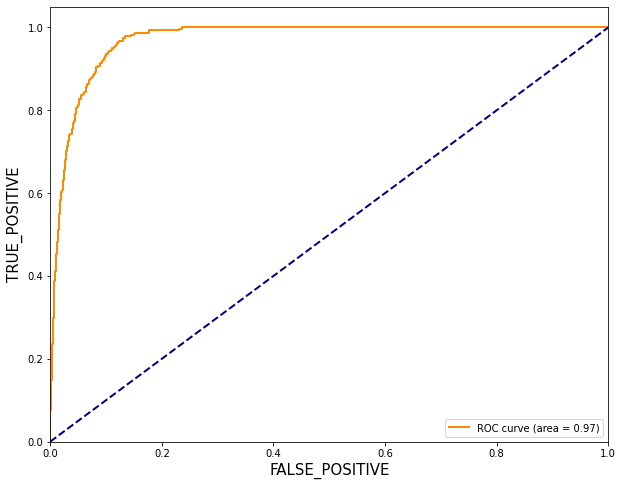

<Figure size 720x576 with 0 Axes>

In [47]:
random_with_grid(X_train, y)

In [42]:
def random_final(train_data, y, test_data, size=0.20):
    
    """Финальное обучение на тренировочном датасете с лучшими параметрами и 
    получением predict_proba для тестового датасета с записей в csv файл"""
    
    test_data = test_data.sort_values('user_id')
    
    X_train, X_test, y_train, y_test = train_test_split(train_data, y.to_frame(), test_size=size, random_state=42)
    
    pipe = RandomForestClassifier(max_depth=7, n_estimators=32,  random_state=42)
    pipe.fit(X_train, y_train)
    
    ypred_prob = pipe.predict_proba(X_test)
    
    roc_score = roc_auc_score(y_test, ypred_prob[:, 1])
    score = pipe.score(X_test, y_test)
    print(f"Правильность на валид наборе: {score:.3f}")
    print(f"Roc_auc_score на валид наборе: {roc_score:.5f}")
    
    ypred_prob_final = pipe.predict_proba(test_data)
    result = test_data['user_id'].to_frame()
    result['is_gone'] = ypred_prob_final[:, 1]
    result[['user_id', 'is_gone']].to_csv(f'my_predict_{roc_score:.5f}.csv', index=False)
    print(f'Результы записанны в файл my_predict_{roc_score:.5f}.csv')

ЭКСПОРТ ФАЙЛА

In [43]:
random_final(X_train, y, X_test)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Правильность на валид наборе: 0.942
Roc_auc_score на валид наборе: 0.97187
Результы записанны в файл my_predict_0.97187.csv
